In [1]:
import sys
print sys.path

['', '//anaconda/lib/python27.zip', '//anaconda/lib/python2.7', '//anaconda/lib/python2.7/plat-linux2', '//anaconda/lib/python2.7/lib-tk', '//anaconda/lib/python2.7/lib-old', '//anaconda/lib/python2.7/lib-dynload', '//anaconda/lib/python2.7/site-packages', '//anaconda/lib/python2.7/site-packages/Sphinx-1.3.1-py2.7.egg', '//anaconda/lib/python2.7/site-packages/cryptography-0.9.1-py2.7-linux-x86_64.egg', '//anaconda/lib/python2.7/site-packages/rpy2-2.5.6-py2.7-linux-x86_64.egg', '//anaconda/lib/python2.7/site-packages/setuptools-20.3-py2.7.egg', '//anaconda/lib/python2.7/site-packages/singledispatch-3.4.0.3-py2.7.egg', '//anaconda/lib/python2.7/site-packages/IPython/extensions']


In [2]:
sys.path.remove('//anaconda/lib/python2.7/site-packages')

sys.path.insert(0,'/global/homes/q/qpzhang/anaconda/lib/python2.7/site-packages')

In [3]:
print sys.path

['/global/homes/q/qpzhang/anaconda/lib/python2.7/site-packages', '', '//anaconda/lib/python27.zip', '//anaconda/lib/python2.7', '//anaconda/lib/python2.7/plat-linux2', '//anaconda/lib/python2.7/lib-tk', '//anaconda/lib/python2.7/lib-old', '//anaconda/lib/python2.7/lib-dynload', '//anaconda/lib/python2.7/site-packages/Sphinx-1.3.1-py2.7.egg', '//anaconda/lib/python2.7/site-packages/cryptography-0.9.1-py2.7-linux-x86_64.egg', '//anaconda/lib/python2.7/site-packages/rpy2-2.5.6-py2.7-linux-x86_64.egg', '//anaconda/lib/python2.7/site-packages/setuptools-20.3-py2.7.egg', '//anaconda/lib/python2.7/site-packages/singledispatch-3.4.0.3-py2.7.egg', '//anaconda/lib/python2.7/site-packages/IPython/extensions']


In [47]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib
matplotlib.style.use('ggplot')

In [5]:
import pandas as pd
print pd.__version__

0.18.1


In [6]:
file_xml_obj = open("/global/projectb/scratch/qpzhang/Full_Training/Pfam/Vfam_run/logistics_report/model.xml", 'r')
p = re.compile(r'name="(field_\d+)" coefficient="(.+)"')

coefficient = {}
for line in file_xml_obj.readlines():
    line = line.rstrip()
    #print line
    if "NumericPredictor name=" in line:
        #print line
        g = p.search(line).groups()
        coefficient[g[0]] = g[1]

series_coefficient = pd.Series(coefficient)
    

In [8]:
df_coefficient = pd.DataFrame(series_coefficient)

In [9]:
df_coefficient.columns = ['coefficient']

In [10]:
df_coefficient['feature_id'] = df_coefficient.index

In [11]:
df_coefficient.index = [int(x.split("_")[1])+1 for x in df_coefficient['feature_id']]

In [12]:
(df_coefficient.index <=21880) | (df_coefficient.index >=30000)

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [13]:
s=np.array([1,2,3,4,5])
(s<3) | (s>4)


array([ True,  True, False, False,  True], dtype=bool)

In [14]:
s>4

array([False, False, False, False,  True], dtype=bool)

In [15]:
df_coefficient_clean = df_coefficient[(df_coefficient.index <=21880) | (df_coefficient.index >=30000)]

In [17]:
df_xFam_name = pd.read_csv('/global/projectb/scratch/qpzhang/Full_Training/Pfam/vFam_Pfam.name',sep = ' ',header=None)

In [18]:
df_xFam = pd.DataFrame(pd.Series(df_xFam_name[2])) 

In [19]:
df_xFam.index = [x+1 for x in df_xFam.index]
df_xFam.columns = ['feature_name']

In [21]:
import itertools
from Bio.Seq import Seq
def iterate_kmer(k):
    """ get the list of tetramers"""
    bases = ['A','C','T','G']
    kmers = [''.join(p) for p in itertools.product(bases, repeat=k)]
#    print kmers
    core_kmer = []
    for kmer in kmers:
        if not str(Seq(kmer).reverse_complement()) in core_kmer:
            core_kmer.append(kmer)
#    print core_kmer
#    print len(core_kmer)
    return core_kmer

core_kmer = iterate_kmer(4)

In [22]:
df_kmers = pd.DataFrame(core_kmer)

In [23]:
df_kmers.index = [x+30000 for x in df_kmers.index]

In [24]:
df_kmers.columns = ['feature_name']
df_kmers['type'] = 'kmers'

In [26]:
bases = ['A','C','T','G']
kmers = [''.join(p) for p in itertools.product(bases, repeat=3)]


In [27]:
hmm_dict = {}
for i in range(30136,30136+64):
    hmm_dict[i] = 'COD1_1'+kmers[i-30136]
for i in range(30136+64,30136+128):
    hmm_dict[i] = 'COD1_2'+kmers[i-30136-64]
for i in range(30136+128,30136+192):
    hmm_dict[i] = 'COD1_3'+kmers[i-30136-128] 
for i in range(30136+192, 30136+256):
    hmm_dict[i] = 'NONC_'+kmers[i-(30136+192)]
df_hmm = pd.DataFrame(pd.Series(hmm_dict))
df_hmm.columns = ['feature_name']
df_hmm['type'] = 'HMM'

In [29]:
frames = [df_kmers,df_hmm,df_xFam]

In [30]:
feature_pd = pd.concat(frames)

In [31]:
df_full = df_coefficient_clean.join(feature_pd, how='outer')

In [32]:
df_full['coefficient'] = pd.to_numeric(df_full['coefficient'])

In [48]:
plt.figure()

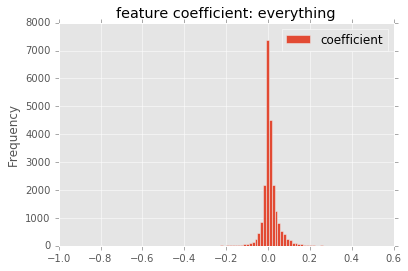

In [72]:
df_full.plot.hist(bins=100)
plt.title('feature coefficient: everything')

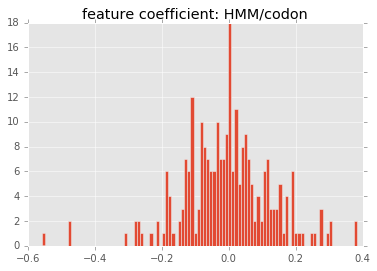

In [71]:
df_full[(df_full.type=="HMM")].hist(bins=100)
plt.title('feature coefficient: HMM/codon')

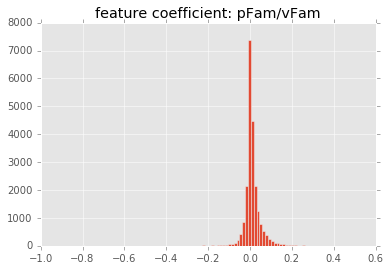

In [69]:
df_full[(df_full.type=="xFam")].hist(bins=100)
plt.title('feature coefficient: pFam/vFam')

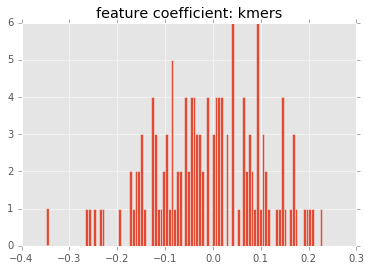

In [68]:
df_full[(df_full.type=="kmers")].hist(bins=100,label='kmers')
plt.title('feature coefficient: kmers')

In [42]:
result_sort = df_full.sort_values(by='coefficient')

In [43]:
result_sort

,coefficient,feature_id,feature_name,type
1799,-0.801489,field_1798,vFam_21,xFam
30330,-0.556631,field_30329,NONC_AAT,HMM
18412,-0.541658,field_18411,RdRP_4,xFam
18410,-0.503262,field_18409,RdRP_2,xFam
30332,-0.481411,field_30331,NONC_ACA,HMM
30256,-0.472777,field_30255,COD1_2GTA,HMM
549,-0.450071,field_548,vFam_112,xFam
4949,-0.406189,field_4948,vFam_3479,xFam
21213,-0.398519,field_21212,Viral_helicase1,xFam
453,-0.391459,field_452,vFam_29,xFam


In [74]:
result_sort.to_csv("sort_coefficient.csv")